In [1]:
from common_train_utils import *
from draw_candle_image import *
from keras import layers, Model
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ta
import ta.momentum
import ta.trend
import tensorflow as tf
from functools import partial

In [2]:
dataset_folder = "./ctg_vn_dataset_5_2_1_2021_2024_test_2023_2024"

In [3]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [4]:
dataset_test = load_dataset_test(dataset_folder)

In [5]:
for images, labels in dataset_test.take(1):
    print(images.shape)
    print(labels.shape)
    

(287, 287, 3)
(9, 4)


In [6]:
image_shape = tuple(images.shape)

In [7]:
image_shape

(287, 287, 3)

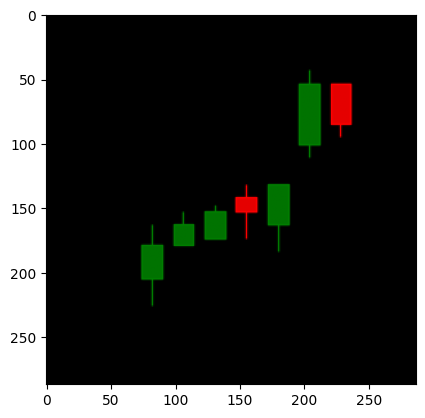

In [8]:
plt.imshow(images)

In [9]:
dataset_test

<_LoadDataset element_spec=(TensorSpec(shape=(287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(9, 4), dtype=tf.float64, name=None))>

In [10]:
len(dataset_test)

39

In [11]:
dataset_train = load_dataset_train(dataset_folder, candle_type_and_directory_save)

folder: bullish_engulfing, 		 total: 32 images
folder: bearish_engulfing, 		 total: 40 images
folder: star_doji, 		 total: 0 images
folder: dragonfly_doji, 		 total: 0 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 19 images
folder: evening_star, 		 total: 19 images
folder: hammer, 		 total: 26 images
folder: inverted_hammer, 		 total: 29 images
folder: harami_down, 		 total: 32 images
folder: harami_up, 		 total: 41 images
folder: tweezer_top, 		 total: 14 images
folder: tweezer_bottom, 		 total: 20 images
folder: marubozu, 		 total: 37 images
folder: spin, 		 total: 24 images
folder: next_3_day_up, 		 total: 109 images
folder: next_3_day_down, 		 total: 93 images


In [12]:
len(dataset_train)

535

In [13]:
dataset_train_1 = dataset_train.shuffle(100).batch(32)
dataset_test_1 = dataset_test.shuffle(100).batch(32)

In [14]:
get_close_feature_1 = partial(get_close_feature, days_result, False)

In [15]:
dataset_train_2 = dataset_train_1.map(get_close_feature_1)
dataset_test_2 = dataset_test_1.map(get_close_feature_1)

In [16]:
dataset_train_2

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None))>

In [17]:
dataset_test_2

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None))>

In [18]:
image_shape

(287, 287, 3)

In [19]:
# 1. Base CNN Model
cnn_base = keras.applications.EfficientNetB7(include_top=False, input_shape=image_shape, weights='imagenet')
cnn_base.trainable = False  # Freeze the base model

# 2. Custom layers to process CNN output for 1 image
cnn_output = layers.GlobalAveragePooling2D()(cnn_base.output)
cnn_output = layers.Dense(128, activation='relu')(cnn_output)
cnn_output = layers.Dropout(0.3)(cnn_output)

# Wrap CNN in a model to apply it later
cnn_model = keras.models.Model(inputs=cnn_base.input, outputs=cnn_output)

# 3. Sequential model for LSTM
# model = keras.models.Sequential([
#     # TimeDistributed wrapper for CNN to handle sequences
#     layers.TimeDistributed(cnn_model),
#     layers.LSTM(64, activation='relu'),  # Output for 1 day input
#     layers.RepeatVector(days_result),  # Repeat the output 6 times to match output sequence length
#     layers.LSTM(64, activation='relu', return_sequences=True),  # LSTM for output sequence
#     layers.TimeDistributed(layers.Dense(1))  # Output layer for each day in 6-day sequence
# ])

model = keras.models.Sequential([
    # TimeDistributed wrapper for CNN to handle sequences
    cnn_model,
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 128)            │    64,425,495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,429,755 (245.78 MB)

 Trainable params: 332,068 (1.27 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

# Summary of the model


In [ ]:
# def expand_to_one_time(features, labels):
#     features = tf.expand_dims(features, axis=1)
#     return features, labels

# dataset_train_3 = dataset_train_2.map(expand_to_one_time)
# dataset_test_3 = dataset_test_2.map(expand_to_one_time)

In [ ]:
# dataset_train_3

<_MapDataset element_spec=(TensorSpec(shape=(None, 1, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [ ]:
# model.fit(dataset_train_3, epochs=20, validation_data=dataset_test_3)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - loss: 6.4254 - mae: 1.7991 - val_loss: 2.2260 - val_mae: 1.1049
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - loss: 6.5000 - mae: 1.8202 - val_loss: 2.2104 - val_mae: 1.1003
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - loss: 7.0136 - mae: 1.8554 - val_loss: 2.2192 - val_mae: 1.1030
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - loss: 6.7242 - mae: 1.8615 - val_loss: 2.2065 - val_mae: 1.0989
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - loss: 6.8698 - mae: 1.8380 - val_loss: 2.2147 - val_mae: 1.1016
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - loss: 7.5076 - mae: 1.9332 - val_loss: 2.2061 - val_mae: 1.0985
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - loss: 6.6314 - mae: 1.8450 - val_loss: 2.2153 - val_mae: 1.1017
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - loss: 6.7379 - mae: 1.8638 - val_loss: 2.1995 - val_mae: 1.0956
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - loss: 7.038

In [21]:
model.fit(dataset_train_2, epochs=20, validation_data=dataset_test_2)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - loss: 413.1545 - mae: 15.6764 - val_loss: 326.5573 - val_mae: 13.7879
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - loss: 397.0016 - mae: 15.4145 - val_loss: 327.6430 - val_mae: 13.9072
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - loss: 418.8445 - mae: 15.9353 - val_loss: 325.5973 - val_mae: 13.8991
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - loss: 418.5931 - mae: 15.9636 - val_loss: 327.8704 - val_mae: 13.9408
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - loss: 408.9280 - mae: 15.8238 - val_loss: 315.7993 - val_mae: 13.5244
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - loss: 430.0897 - mae: 16.2588 - val_loss: 325.2728 - val_mae: 13.9771
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step - loss: 421.2063 - mae: 16.0959 - val_loss: 325.9212 - val_mae: 13.9773
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - loss: 399.0344 - mae: 15.5740 - val_loss: 315.9207 - val_mae: 13.6098
Epoch 9/20
17/17

In [22]:
model.save(f"{dataset_folder}/model_2.keras")